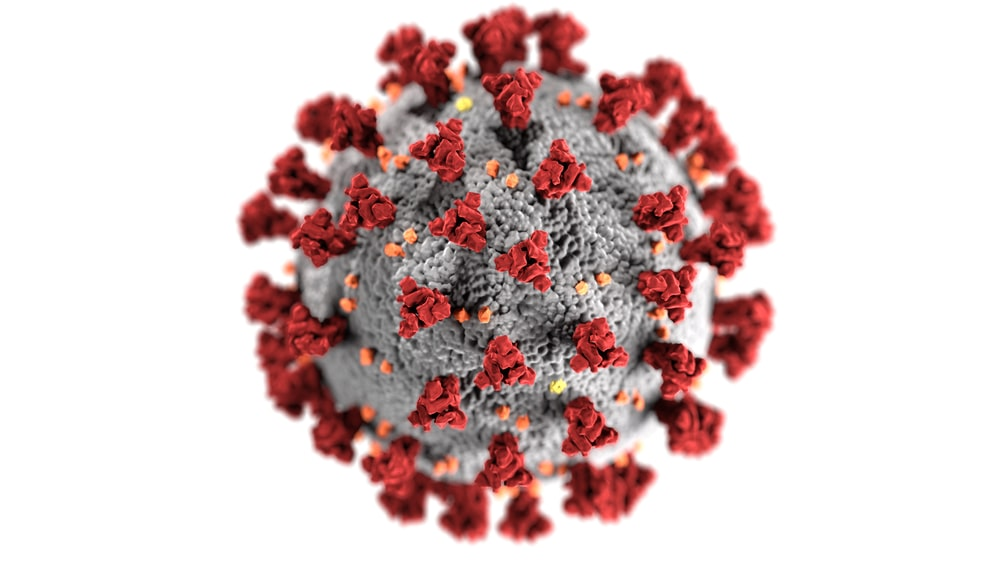
<font color='blue'>
    
# Contents


- Population Wise Analysis
- The number of days go out (template data)
- Functions
- Raw data: the number of cases
- Data Cleaning: the number of cases
- SIR
- Grouping by growth factor
- Calculate growth factor
- Grouping countires based on growth factor
- Group 1: Outbreaking, growth factor >> 1 for the last 7 days
- Group 2: Stopping, growth factor << 1 for the last 7 days
- Group 3: At a crossroad, the others
- Trend analysis
- Most critical country
- Non-dimensional SIR model

# Introduction:

- Coronavirus disease 2019 (COVID-19) is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The disease was first identified in December 2019 in Wuhan, the capital of China's Hubei province, and has since spread globally, resulting in the ongoing 2019–20 coronavirus pandemic. Common symptoms include fever, cough, and shortness of breath. Other symptoms may include fatigue, muscle pain, diarrhea, sore throat, loss of smell and abdominal pain. While the majority of cases result in mild symptoms, some progress to viral pneumonia and multi-organ failure. As of 13 April 2020, more than 1.8 million cases have been reported in more than 200 countries and territories, resulting in more than 114090 deaths. More than 421497 people have recovered.


# Transmission:

- Some details about how the disease is spread are still being determined. The WHO and CDC say it is primarily spread during close contact and by small droplets produced when people cough, sneeze or talk; with close contact being within 1–3 m (3 ft. 3 in–9 ft. 10 in). A study in Singapore found that uncovered coughing can lead to droplets traveling up to 4.5 meters (15 feet). A second study, produced during the 2020 pandemic, found that advice on the distance droplets could travel might be based on old 1930s research which ignored the protective effect and speed of the warm moist outbreath surrounding the droplets; it advised that droplets can travel around 7–8 meters. 
</font>




In [ ]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import os
import math
import optuna
import warnings
import matplotlib
%matplotlib inline
import pystan.misc
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.cm as cm
import dask.dataframe as dd
from fbprophet import Prophet
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.cluster import KMeans
from collections import defaultdict
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
optuna.logging.disable_default_handler()
pd.plotting.register_matplotlib_converters()
from matplotlib.ticker import ScalarFormatter
from dateutil.relativedelta import relativedelta
from fbprophet.plot import add_changepoints_to_plot
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
confirmed_df  = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df     = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [ ]:
population_df = pd.read_csv('../input/covid19-global-forecasting-locations-population/locations_population.csv')
population_df.head(5)

In [ ]:
x = pd.DataFrame(population_df.isnull().sum()).T
x.style.background_gradient(cmap='Reds',axis=1)

# **Total Population**
<font color = 'blue'>
    
- The highly populated country has more chances to get infected quickly. The following are top populated countries across the globe.<font>



In [ ]:
df_pop = population_df.copy()
df_pop = df_pop.rename({ 'Province.State' : 'province', 'Country.Region': 'country'}, axis = 1)
cols = ['country', 'province', 'Population']
df_pop = df_pop.loc[:,cols].fillna('-')
df_pop.loc[df_pop['country'] == df_pop['province'],'province'] = '-'


total = df_pop.loc[df_pop['province'] != '-', :].groupby('country').sum()
total_pop = total.reset_index().assign(Province="-")

df_pop = pd.concat([df_pop, total_pop], axis=0, sort=True)
df_pop = df_pop.drop_duplicates(subset=["country", "province"], keep="first")
# Global
global_value = df_pop.loc[df_pop["province"] == "-",'Population'].sum()
df_pop = df_pop.append(pd.Series(["Global", "-", global_value], index=cols), ignore_index=True)
# Sorting
df_pop = df_pop.sort_values("Population", ascending=False).reset_index(drop=True)
df_pop = df_pop.loc[:, cols]
population_df = df_pop.copy()
population_df.head()
population_df.style.background_gradient(cmap='Wistia',axis=1)

In [ ]:
df = population_df.loc[population_df["province"] == "-", :]
population_dict = df.set_index("country").to_dict()["Population"]
population_dict

In [ ]:
india = pd.read_csv('../input/population-pyramid-2019/India-2019.csv')
india

In [ ]:
india.sum()

In [ ]:
pyramid_csv_list = list()
for dirname, _, filenames in os.walk("/kaggle/input/population-pyramid-2019/"):
    for filename in filenames:
        name = os.path.join(dirname, filename)
        df = pd.read_csv(name)
        df["Country"], df["Year"], _ = filename.replace(".", "-").split("-")
        pyramid_csv_list.append(df)
pyramid_raw = pd.concat(pyramid_csv_list, sort=True)
pyramid_raw.head()

# Population catagory of different age group

In [ ]:
pyramid_raw["Country"].unique()

In [ ]:
df = pyramid_raw.copy()
df["Country"] = df["Country"].replace(
    {
        "United States of America": "US",
        "United Kingdom": "UK",
    }
)
# Global (WORLD)
_male = [
    349432556, 342927576, 331497486, 316642222, 308286775, 306059387, 309236984,
    276447037, 249389688, 241232876, 222609691, 192215395, 157180267, 128939392,
    87185982, 54754941, 33648953, 15756942, 5327866, 1077791, 124144
]
_female = [
    328509234, 321511867, 309769906, 295553758, 289100903, 288632766, 296293748,
    268371754, 244399176, 238133281, 223162982, 195633743, 164961323, 140704320,
    101491347, 69026831, 48281201, 26429329, 11352182, 3055845, 449279
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Global",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Sweden
_male = [
    307116,304759,296771,270840,291723,376952,343311,315086,312017,336452,342117,306949,279609,265511,
    273061,195029,113166,61775,26170,6768,415]
_female = [ 290553, 288817, 280944,257677, 274760, 361526, 330153,300752,301288,327453,331458,300084,
    280009,272149,286879,212480,143654,97633,52624,18130,1771]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Sweden",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Philippines
_male = [5534962,5820604,5538414,5383822,5149849,4710777,4061897,3581091,3237426, 2832825,2482953,2015857,
    1556935,1082875,668107,364200,199400,73508,17327,3035,208 ]
_female = [5240508,5541514,5273495,5029137,4896316,4589506,3982681,3544279,3191565,2825286,2521463,2112380,
    1714689,1285782,895866,567282,360751,155294,57969,13376,1411]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Philippines",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Arrange
df["Population"] = df["F"] + df["M"]
df = df.pivot_table(
    index="Age", columns=["Country"], values="Population", aggfunc="last"
)
df = df.astype(np.int64).reset_index().rename({"Age": "Age_bin"}, axis=1)
series = df["Age_bin"].str.replace("+", "-122")
df[["Age_first", "Age_last"]] = series.str.split("-", expand=True).astype(np.int64)
df = df.drop("Age_bin", axis=1)
series = df["Age_last"]
df = df.apply(lambda x: x[:-2] / (x[-1] - x[-2] + 1), axis=1)
df["Age"] = series
df = pd.merge(df, pd.DataFrame({"Age": np.arange(0, 123, 1)}), on="Age", how="right", sort=True)
df = df.fillna(method="bfill").astype(np.int64)
df = df.set_index("Age")
pyramid_df = df.copy()
pyramid_df.style.background_gradient(cmap='Wistia',axis=1)

## The number of days go out

In [ ]:
# @marcoferrante estimation
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)
# Adjustment by author
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)
# Show dataset
_out_df = df.copy()
_out_df.style.background_gradient(cmap='Wistia',axis=1)

In [ ]:
df = pyramid_df.cumsum()
countries = df.columns[:]
df = pd.merge(_out_df, df, left_on="Age_last", right_on="Age", how="left")
_first = df.loc[df.index[0], countries]
df[countries] = df[countries].diff()
df.loc[df.index[0], countries] = _first
df[countries] = df[countries].apply(lambda x: x / x.sum(), axis=0)
out_df = df.copy()
#out_df.style.background_gradient(cmap='Wistia',axis=1)

# **The number of the day goes out**
<font color = 'blue'>
 
- There are different age groups people who go outside on different days. So here we have analyzed which age group has most days outside the home. The more they go outside can have more chances to infected by the COVID-19 virus. <font>

In [ ]:
def go_out(country, out_df=out_df):
    df = out_df.copy()
    try:
        series = df[country]
    except KeyError:
        raise KeyError(f"Population pyramid data of {country} is not defined!")
    df = df.iloc[:, :6]
    df["Portion"] = series
    return df
go_out("Global").style.background_gradient(cmap='Reds',axis=1)

# **Functions**

In [ ]:
def line_plot(df, title, xlabel=None, ylabel="Cases",
              h=None, v=None, xlim=(None, None), ylim=(0, None),
              math_scale=True, y_logscale=False, y_integer=False,
              show_legend=True, bbox_to_anchor=(1.02, 0),  bbox_loc="lower left"):
    ax = df.plot()
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    if y_logscale:
        ax.set_yscale("log")
        if ylim[0] == 0:
            ylim = (None, None)
    if y_integer:
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        ax.yaxis.set_major_formatter(fmt)
    
    #ax.figure(figsize = (10,8)) 
    ax.grid()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    if show_legend:
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=bbox_loc, borderaxespad=0)
    else:
        ax.legend().set_visible(False)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle="--")
    if v is not None:
        if not isinstance(v, list):
            v = [v]
        for value in v:
            ax.axvline(x=value, color="black", linestyle="--")
    plt.figure(figsize = (10,8))
    plt.tight_layout()
    plt.show()

# **Raw data: the number of cases**

In [ ]:
raw = pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv")
raw.head().style.background_gradient(cmap='Reds',axis=1 )

In [ ]:
raw.describe().style.background_gradient(cmap='Reds',axis=1)

# Data Cleening: the number of cases
Note: "Infected" = "Confirmed" - "Deaths" - "Recovered"

In [ ]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}

In [ ]:
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
        "Congo (Brazzaville)": "Congo",
        "The, Bahamas": "Bahamas",
    }
)
df["Province"] = df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess",
        "Diamond Princess cruise ship": "Diamond Princess"
    }
)
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail().style.background_gradient(cmap='Reds',axis=1)

In [ ]:
ncov_df_ungrouped.describe(include="all").fillna("-").style.background_gradient(cmap='Reds',axis=1)

In [ ]:
", ".join(ncov_df_ungrouped["Country"].unique().tolist())

In [ ]:
total_df = ncov_df_ungrouped.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail().style.background_gradient(cmap='Reds',axis=1)

In [ ]:
f"{(total_df.index.max() - total_df.index.min()).days} days have passed from the date of the first record."

In [ ]:
line_plot(total_df[data_cols], "Total number of cases over time")

# **SIR Model**
<font color = 'blue'>
    
- An SIR model is an epidemiological model that computes the theoretical number of people infected with a contagious illness in a closed population over time. The name of this class of models derives from the fact that they involve coupled equations relating the number of susceptible people S(t), number of people infected I(t), and number of people who have recovered R(t). One of the simplest SIR models is the Kermack-McKendrick model.
             
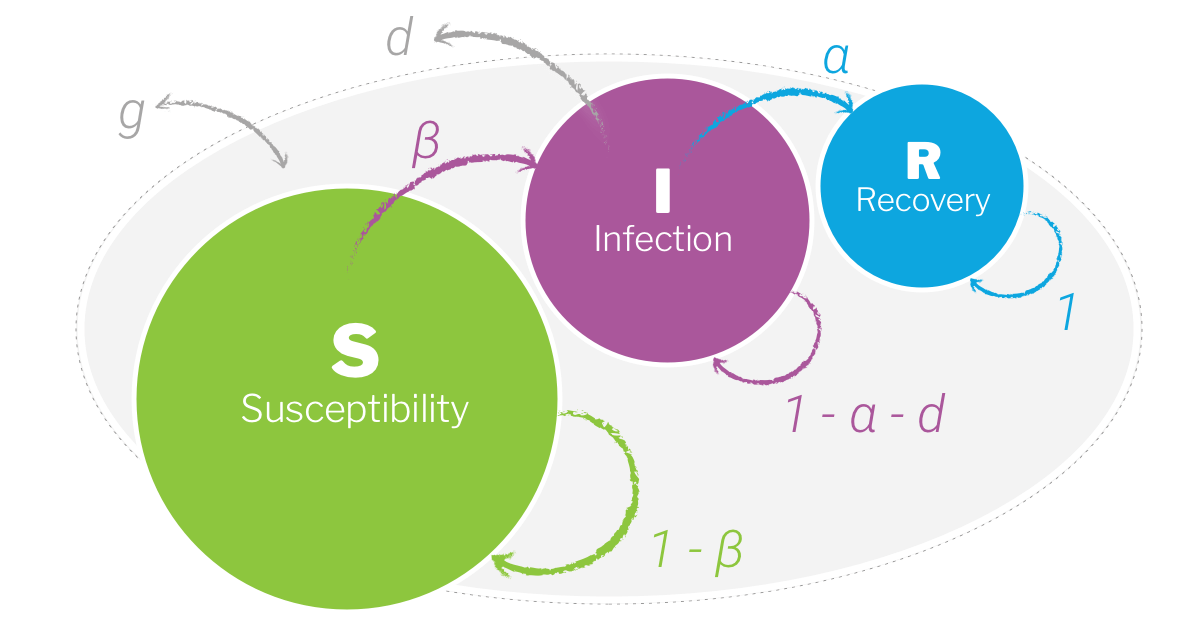
 

In [ ]:

confirmed_df        = confirmed_df.groupby(['Country/Region']).sum()
recoveries_df       = recoveries_df.groupby(['Country/Region']).sum()
deaths_df           = deaths_df.groupby(['Country/Region']).sum()

dates               = np.array([dt[:-3] for dt in confirmed_df.columns[2:]])

date_ticks     = np.arange(0, len(dates), 7) 
date_labels    = dates[date_ticks]

print('Data available till:', confirmed_df.columns[-1])

In [ ]:
def sir_model_fitting(country, cluster_population=500000000, passed_data=0, show_plots=1, days_to_predict=10):
    """Fit SIR model and plot data vs model result for 90 days for comparison"""
    if passed_data:
        ydata   = country
        country = 'Worldwide (excluding China)' 
    else:
        confirmed          = np.array(confirmed_df.loc[country, confirmed_df.columns[2:]])
        recovered          = np.array(recoveries_df.loc[country, recoveries_df.columns[2:]])
        deaths             = np.array(deaths_df.loc[country, deaths_df.columns[2:]])
        ydata              = confirmed - recovered - deaths
        
    xdata = np.arange(len(ydata))+1
    days_to_predict = len(xdata) + days_to_predict
    ind   = np.where(ydata>0)[0][0]
    model_output = ydata[ind:]
    model_input = np.arange(len(model_output))

    inf0 = model_output[0]
    sus0 = cluster_population - inf0
    rec0 = 0

    def sir_model(y, x, beta, gamma):
        sus = -beta * y[0] * y[1]/cluster_population
        rec = gamma * y[1]
        inf = -(sus + rec)
        return sus, inf, rec

    def fit_odeint(x, beta, gamma):
        return odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

    popt, pcov = curve_fit(fit_odeint, model_input, model_output)
    fitted = fit_odeint(np.arange(days_to_predict-ind), *popt)
    fitted = np.append(np.zeros((ind,1)), fitted)

    if show_plots:
        fig = plt.figure(figsize = (13,8))
        plt.plot(xdata, ydata, 'o')
        plt.plot(np.arange(len(fitted))+1, fitted)
        plt.plot([len(xdata), len(xdata)],[0, np.max(fitted)], ':k')
        plt.legend(['data', 'model prediction', "today we're here"])
        plt.title("SIR model fit to 'active cases' of " + country)
        plt.ylabel("Population infected")
        plt.xlabel("Days since 22 Jan 2020")
        plt.grid('best')

        print("Optimal parameters: beta =", round(popt[0],3), " gamma = ", round(popt[1],3))
    #     print('Goodness of fit', round(r2_score(ydata, fit_odeint(xdata, *popt)),4)*100, ' %')
        print('Optimal parameters Standard Dev: std_beta =', np.round(np.sqrt(pcov[0][0]),3), ' std_gamma =', np.round(np.sqrt(pcov[1][1]),3))
    else:
        return fitted

In [ ]:
#  def data_plot_country(country, show_plots=1): 
#     confirmed          = np.array(confirmed_df.loc[country, confirmed_df.columns[2:]])
#     recovered          = np.array(recoveries_df.loc[country, recoveries_df.columns[2:]])
#     deaths             = np.array(deaths_df.loc[country, deaths_df.columns[2:]])
        
#     if show_plots:
#         fig = plt.figure()
#         plt.stackplot(dates, confirmed - recovered - deaths, recovered, deaths, labels=['active cases', 'recovered','deaths'])
#         plt.grid()
#         plt.title('Cases in ' + country)
#         plt.ylabel("# of cases")
#         plt.xticks(date_ticks, date_labels)
#         plt.legend(loc='upper left')
#         print('Mortality rate:', round(deaths[-1]/confirmed[-1]*100,2), '%')
    
#     return confirmed, recovered, deaths

In [ ]:
def select_area(ncov_df, group="Date", places=None, areas=None, excluded_places=None,
                start_date=None, end_date=None, date_format="%d%b%Y"):
    # Select the target records
    df = ncov_df.copy()
    if (places is not None) or (excluded_places is not None):
        c_series = df["Country"]
        p_series = df["Province"]
        if places is not None:
            df = pd.DataFrame(columns=ncov_df.columns)
            for (c, p) in places:
                if c is None:
                    raise Exception("places: Country must be specified!")
                if p is None:
                    new_df = ncov_df.loc[c_series == c, :]
                else:
                    new_df = ncov_df.loc[(c_series == c) & (p_series == p), :]
                df = pd.concat([df, new_df], axis=0)
        if excluded_places is not None:
            for (c, p) in excluded_places:
                if c is None:
                    raise Exception("excluded_places: Country must be specified!")
                if p is None:
                    df = df.loc[c_series != c, :]
                else:
                    c_df = df.loc[(c_series == c) & (p_series != p), :]
                    other_df = df.loc[c_series != c, :]
                    df = pd.concat([c_df, other_df], axis=0)
    if areas is not None:
        df = df.loc[df["Area"].isin(areas), :]
    if group is not None:
        df = df.groupby(group).sum().reset_index()
    # Range of date
    if start_date is not None:
        df = df.loc[df["Date"] >= datetime.strptime(start_date, date_format), :]
    if end_date is not None:
        df = df.loc[df["Date"] <= datetime.strptime(end_date, date_format), :]
    # Only use the records with Confirmed > 0
    try:
        df = df.loc[df["Confirmed"] > 0, :]
    except KeyError:
        pass
    # Aleart empty
    if df.empty:
        raise Exception("The output dataframe is empty!")
    return df

In [ ]:
def create_target_df(ncov_df, total_population,
                     confirmed="Confirmed", recovered="Recovered", fatal="Deaths", **kwargs):
    # Select the target records
    df = select_area(ncov_df, **kwargs)
    first_date = df.loc[df.index[0], "Date"]
    # column T
    df["T"] = ((df["Date"] - first_date).dt.total_seconds() / 60).astype(int)
    # coluns except T
    cols = [confirmed, recovered, fatal]
    if not set(cols).issubset(set(df.columns)):
        raise KeyError(f"ncov_df must have {', '.join(cols)} column!")
    df["Susceptible"] = total_population - df[confirmed]
    df["Infected"] = df[confirmed] - df[recovered] - df[fatal]
    df["Recovered"] = df[recovered]
    df["Fatal"] = df.loc[:, fatal]
    response_variables = ["Susceptible", "Infected", "Recovered", "Fatal"]
    # Return
    target_df = df.loc[:, ["T", *response_variables]]
    return (first_date, target_df)

In [ ]:
def simulation(model, initials, step_n, **params):
    tstart, dt, tend = 0, 1, step_n
    sol = solve_ivp(
        fun=model(**params),
        t_span=[tstart, tend],
        y0=np.array(initials, dtype=np.float64),
        t_eval=np.arange(tstart, tend + dt, dt),
        dense_output=False  # True
    )
    t_df = pd.Series(data=sol["t"], name="t")
    y_df = pd.DataFrame(data=sol["y"].T.copy(), columns=model.VARIABLES)
    sim_df = pd.concat([t_df, y_df], axis=1)
    return sim_df

In [ ]:
class ModelBase(object):
    NAME = "Model"
    VARIABLES = ["x"]
    PRIORITIES = np.array([1])
    QUANTILE_RANGE = [0.3, 0.7]
    MONOTONIC = ["x"]

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = dict()
        return param_dict

    @staticmethod
    def calc_variables(df):
        return df

    @staticmethod
    def calc_variables_reverse(df):
        return df

    @classmethod
    def create_dataset(cls, ncov_df, total_population, **kwargs):
        start_date, target_df = create_target_df(ncov_df, total_population, **kwargs)
        df = cls.calc_variables(target_df).set_index("T") / total_population
        df.columns = [n.lower() for n in df.columns]
        initials = df.iloc[0, :].values
        df = df.reset_index()
        Tend = df.iloc[-1, 0]
        return (start_date, initials, Tend, df)

    def calc_r0(self):
        return None

    def calc_days_dict(self, tau):
        return dict()

In [ ]:
class SIR(ModelBase):
    NAME = "SIR"
    VARIABLES = ["x", "y", "z"]
    PRIORITIES = np.array([1, 1, 1])
    MONOTONIC = ["z"]

    def __init__(self, rho, sigma):
        super().__init__()
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - self.sigma * y
        # dzdt = self.sigma * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - self.sigma * X[1]
        dzdt = self.sigma * X[1]
        return np.array([dxdt, dydt, dzdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"] + df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered/Deaths"] = df["Z"]
        return df

    def calc_r0(self):
        if self.sigma == 0:
            return np.nan
        r0 = self.rho / self.sigma
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

## The number of cases in Japan

In [ ]:
jpn_ncov_raw = pd.read_csv("/kaggle/input/covid19-dataset-in-japan/covid_jpn_total.csv")
jpn_ncov_raw.tail()

In [ ]:
# https://www.kaggle.com/lisphilar/eda-of-japan-dataset
# and remove returunee/airport cases
df = jpn_ncov_raw.copy()
df.dropna(how="any", inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df.groupby("Location").apply(
    lambda x: x.set_index("Date").resample("D").interpolate(method="linear")
)
df = df.drop("Location", axis=1).reset_index()
df = df.loc[df["Location"] == "Domestic", :].drop("Location", axis=1)
df = df.set_index("Date").resample("D").last().fillna("ffill")
sel = df.columns.isin(["Location", "Date"])
df.loc[:, ~sel] = df.loc[:, ~sel].astype(np.int64)
jpn_ncov_df = df.copy()
jpn_ncov_df.tail()

# Grouping by growth factor
<font color = 'blue'>
    
* The number of confirmed cases is increasing in many countries, but there are two of countries. In a first-type country, growth factor is larger than 1 and the number of cases is rapidly increasing. In a second-type country, growth factor is less than 1.

## Calculate growth factor
<font color = 'blue'>

Where $C$ is the number of confirmed cases,  
$$\mathrm{Growth\ Factor} = \cfrac{\Delta \mathrm{C}_{n}}{\Delta \mathrm{C}_{n-1}}$$ </font>

In [ ]:
df = ncov_df_ungrouped.pivot_table(
    index="Date", columns="Country", values="Confirmed", aggfunc="sum"
).fillna(method="ffill").fillna(0)
# Growth factor: (delta Number_n) / (delta Number_n)
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean()
df = df.iloc[6:, :]
# round: 0.01
growth_value_df = df.round(2)
growth_value_df.tail()

## Grouping countires based on growth factor
<font color = 'blue'>
    

* Outbreaking: growth factor $>$ 1 for the last 7 days
* Stopping: growth factor $<$ 1 for the last 7 days
* At a crossroad: the others

In [ ]:
df = growth_value_df.copy()
df = df.iloc[-7:, :].T
day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]
# Grouping
more_col, less_col = "GF > 1 [straight days]", "GF < 1 [straight days]"
df[more_col] = (growth_value_df > 1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = (growth_value_df < 1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col, less_col]].apply(
    lambda x: "Outbreaking" if x[0] >= 7 else "Stopping" if x[1] >= 7 else "Crossroad",
    axis=1
)
# Sorting
df = df.loc[:, ["Group", more_col, less_col, *day_cols]]
df["rank1"] = df[more_col] * df[last_date]
df["rank2"] = df[less_col] * df[last_date]
df = df.sort_values(["Group", "rank1", "rank2"], ascending=False)
df = df.drop(["rank1", "rank2"], axis=1)
growth_df = df.copy()
growth_df.head()

In [ ]:
df = pd.merge(ncov_df_ungrouped, growth_df["Group"].reset_index(), on="Country")
ncov_df = df.loc[:, ["Date", "Group", *ncov_df_ungrouped.columns[1:]]]
ncov_df.tail()

## Group 1: Outbreaking, growth factor $>$ 1 for the last 7 days

In [ ]:
pprint(growth_df.loc[growth_df["Group"] == "Outbreaking", :].index.tolist(), compact=True)

In [ ]:
growth_df.loc[growth_df["Group"] == "Outbreaking", :].head()

In [ ]:
df = ncov_df.loc[ncov_df["Group"] == "Outbreaking", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 1 (Outbreaking): Cases over time", y_integer=True)
df.tail()

## Group 2: Stopping, growth factor $<$ 1 for the last 7 days

In [ ]:
pprint(growth_df.loc[growth_df["Group"] == "Stopping", :].index.tolist(), compact=True)

In [ ]:
growth_df.loc[growth_df["Group"] == "Stopping", :].head()

In [ ]:
df = ncov_df.loc[ncov_df["Group"] == "Stopping", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 2 (Stopping): Cases over time", y_integer=True)
df.tail()

## Group 3: At a crossroad, the others

In [ ]:
pprint(growth_df.loc[growth_df["Group"] == "Crossroad", :].index.tolist(), compact=True)

In [ ]:
growth_df.loc[growth_df["Group"] == "Crossroad", :].head()

In [ ]:
df = ncov_df.loc[ncov_df["Group"] == "Crossroad", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 3 (At a crossroad): Cases over time", y_integer=True)
df.tail()

# Trend analysis
<font color = 'blue'>
    
* We will use the data in the most cirical country where the number of days with growth factor $>$ 1 is the longest.

* # Most critical country according to growth factor

In [ ]:
critical_country = growth_df.loc[growth_df["Group"] == "Outbreaking", :].index[0]
critical_country

In [ ]:
critical_df = ncov_df.loc[ncov_df["Country"] == critical_country, ["Date", *data_cols]].groupby("Date").sum()
critical_df.tail()

In [ ]:
line_plot(critical_df, f"{critical_country}: Cases over time", y_integer=True)

In [ ]:
critical_country_start = "25Mar2020"

### Non-dimensional SIR model
<font color = 'blue'>
    

To simplify the model, we will remove the units of the variables from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 \leq (x, y, z, \rho, \sigma) \leq 1$  
$1\leq \tau \leq 1440$  

Basic reproduction number, Non-dimentional parameter, is defined as  
$R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}$  

Estimated Mean Values of $R_0$:  
$R_0$ means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003  
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova  
1.5 : Spring wave of 1918 Spanish influenza in Genova  

When $x=\frac{1}{R_0}$, $\frac{\mathrm{d}y}{\mathrm{d}t}=0$.
<!--This means that the max value of confirmed ($=y+z$) is $1-\frac{1}{R_0}$.-->

In [ ]:
train_dataset = SIR.create_dataset(
    ncov_df, population_dict[critical_country], excluded_places=[(critical_country, None)],
    #start_date=critical_country_start
)
train_start_date, train_initials, train_Tend, train_df = train_dataset
pprint([train_start_date.strftime("%d%b%Y"), train_initials, train_Tend])

In [ ]:
line_plot(
    train_df.set_index("T").drop("x", axis=1),
    "Training data: y(T), z(T)", math_scale=False, ylabel=""
)

In [ ]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0
(eg_rho, eg_sigma)

In [ ]:

eg_df = simulation(SIR, train_initials, step_n=200, rho=eg_rho, sigma=eg_sigma)

In [ ]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0$={0} ($\rho$={1}, $\sigma$={2})".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

<font color = 'blue'>
* India seems to get its peak around the first week of May after that the number of cases will slow down.

In [ ]:
sir_model_fitting('India')

In [ ]:
sir_model_fitting('China')

In [ ]:
sir_model_fitting('Italy')

# Remark

<font color = 'blue'>
    
•	China got the peak after 30 days. Compared to china India will get its peak after 50 days of its first case which shows a better result. 